In [1]:
# ref: 

# https://alexioannides.com/2018/11/07/bayesian-regression-in-pymc3-using-mcmc-variational-inference/
# https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html

# http://stronginference.com/pymc3-release.html
# https://docs.pymc.io/notebooks/getting_started.html

# https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501

In [2]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
np.random.seed(14)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [3]:
''' function definitions '''
# true low-fidelity and true high-fidelity models
f_l = lambda x: (0.5*(6*x-2)**2*np.sin(12*x-4))+(10*(x-0.5))+(-5)
f_h = lambda x: ((6*x-2)**2*np.sin(12*x-4))

In [4]:
N_l = 11 # number of low fidelity data observations
N_h = 4 # number of high fidelity data observations

# [X_l,Y_l] and [X_h,Y_h] are low are high fidelity data respectively.
X_l = np.linspace(0.0, 1.0, N_l)[:, None]

# # for not-nested data
# X_h = np.random.rand(N_h, 1)

# # for nested data
perm = np.random.permutation(N_l)
X_h = X_l[perm[0:N_h]]

Y_l = f_l(X_l)
Y_h = f_h(X_h)

print (X_l.shape, Y_l.shape)
print (X_h.shape, Y_h.shape)

(11, 1) (11, 1)
(4, 1) (4, 1)


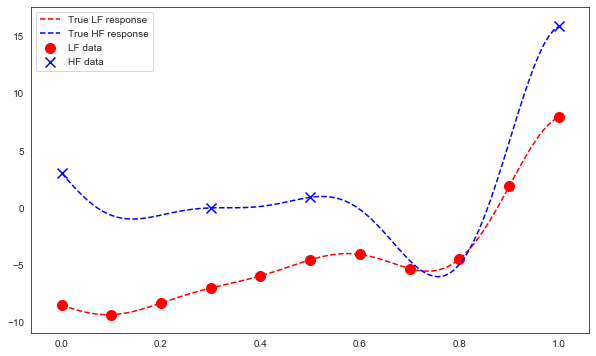

In [5]:
# just to show the plot
X_p = np.linspace(0.0, 1.0, 100)[:, None]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(X_p, f_l(X_p), 'r--', label='True LF response')
ax.scatter(X_l, Y_l, color='red', marker='o', s=100, label='LF data')
ax.plot(X_p, f_h(X_p), 'b--', label='True HF response')
ax.scatter(X_h, Y_h, color='blue', marker='x', s=100, label='HF data')

ax.legend()
plt.show()

## Pymc model

In [6]:
# Building pymc model

H = 10
P = int(H/2)

# Initialize random weights between each layer
init_W_0 = np.random.randn(X_l.shape[1], H).astype(floatX)
init_W_1 = np.random.randn(H, H).astype(floatX)
init_b_0 = np.random.randn(H).astype(floatX)
init_b_1 = np.random.randn(H).astype(floatX)


init_W_00 = np.random.randn(int(H/2), P).astype(floatX)
init_W_10 = np.random.randn(P, 1).astype(floatX)
init_b_00 = np.random.randn(P).astype(floatX)
init_b_10 = np.random.randn(1).astype(floatX)

init_W_01 = np.random.randn(int(H/2), P).astype(floatX)
init_W_11 = np.random.randn(P, 1).astype(floatX)
init_b_01 = np.random.randn(P).astype(floatX)
init_b_11 = np.random.randn(1).astype(floatX)

def swish(x):
    return (theano.tensor.nnet.nnet.sigmoid(x) * x)

def DNN(x_tensor, W_0, b_0, W_1, b_1, W_00, b_00, W_10, b_10, W_01, b_01, W_11, b_11 ):
    act_1 = swish(pm.math.dot(x_tensor,W_0)+b_0)
    act_2 = swish(pm.math.dot(act_1,W_1)+b_1)
    act_2_0 = act_2[:,:int(H/2)]
    act_2_1 = act_2[:,int(-H/2):]
    
    act_10 = swish(pm.math.dot(act_2_0,W_00)+b_00)
    act_20 = pm.math.dot(act_10,W_10)+b_10
    
    act_11 = swish(pm.math.dot(act_2_1,W_01)+b_01)
    act_21 = pm.math.dot(act_11,W_11)+b_11
    
    return act_20,act_21

with pm.Model() as neural_network:
    # Trick: Turning inputs and outputs into shared variables 
    # It's still the same thing, but we can later change the values of the shared variable
    # (to switch in the test-data later) and pymc3 will just use the new data.
    # Kind-of like a pointer we can redirect.
    # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
    y_tensor_low = theano.shared(Y_l)
    x_tensor_low = theano.shared(X_l)
    
    y_tensor_high = theano.shared(Y_h)
    x_tensor_high = theano.shared(X_h)

    #PRIOR
    # BNN 1 
    W_0 = pm.Normal('W_0', 0, sigma=1,
                             shape=(X_l.shape[1], H),
                             testval=init_W_0)
    
    b_0 = pm.Normal('b_0', 0, sigma=1,
                             shape=(H),
                             testval=init_b_0)

    W_1 = pm.Normal('W_1', 0, sigma=1,
                            shape=(H, H),
                            testval=init_W_1)
  
    b_1 = pm.Normal('b_1', 0, sigma=1,
                             shape=(H),
                             testval=init_b_1)
    
    # BNN 2
    W_00 = pm.Normal('W_00', 0, sigma=1,
                             shape=(int(H/2), P),
                             testval=init_W_00)
    
    b_00 = pm.Normal('b_00', 0, sigma=1,
                             shape=(P),
                             testval=init_b_00)

    W_10 = pm.Normal('W_10', 0, sigma=1,
                            shape=(P, 1),
                            testval=init_W_10)
  
    b_10 = pm.Normal('b_10', 0, sigma=1,
                             shape=(1),
                             testval=init_b_10)

    # BNN 3
    W_01 = pm.Normal('W_01', 0, sigma=1,
                             shape=(int(H/2), P),
                             testval=init_W_01)
    
    b_01 = pm.Normal('b_01', 0, sigma=1,
                             shape=(P),
                             testval=init_b_01)

    W_11 = pm.Normal('W_11', 0, sigma=1,
                            shape=(P, 1),
                            testval=init_W_11)
  
    b_11 = pm.Normal('b_11', 0, sigma=1,
                             shape=(1),
                             testval=init_b_11)

        
    # Build neural-network using activation function
    act_out_low = DNN(x_tensor_low, W_0, b_0, W_1, b_1, W_00, b_00, W_10, b_10, W_01, b_01, W_11, b_11 )[0]
    act_out_high = DNN(x_tensor_high, W_0, b_0, W_1, b_1, W_00, b_00, W_10, b_10, W_01, b_01, W_11, b_11 )[1]

    # LIKELIHOOD
    out1 = pm.Normal('out1', mu=act_out_low, sigma=0.01, observed=y_tensor_low)
    out2 = pm.Normal('out2', mu=act_out_high, sigma=0.01, observed=y_tensor_high)

In [7]:
# Now we would like to make some predictions
# Namely, we wish to predict at this dense set of points:
X_p = np.linspace(0.0, 1.0, 100)[:, None]
print (X_p.shape)

(100, 1)


(5, 100)
(5, 100)


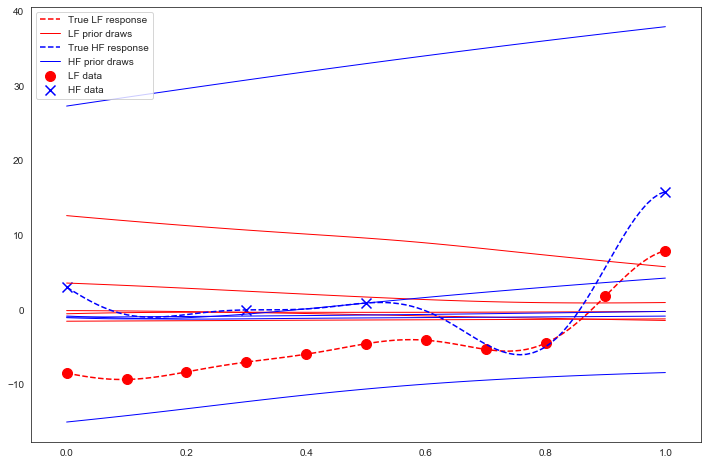

In [8]:
#checking prior draws

with neural_network:
    preds_low =[DNN(X_p, W_0.random(), b_0.random(), W_1.random(), b_1.random(), 
                    W_00.random(), b_00.random(), W_10.random(), b_10.random(), 
                    W_01.random(), b_01.random(), W_11.random(), b_11.random())[0].eval()
     for _ in range(5)]
    preds_low = np.asarray(preds_low)
    outputs_low = preds_low.reshape(preds_low.shape[0],preds_low.shape[1])
    print(np.shape(outputs_low))

    preds_high =[DNN(X_p, W_0.random(), b_0.random(), W_1.random(), b_1.random(), 
                     W_00.random(), b_00.random(), W_10.random(), b_10.random(),
                     W_01.random(), b_01.random(), W_11.random(), b_11.random())[1].eval()
     for _ in range(5)]
    preds_high = np.asarray(preds_high)
    outputs_high = preds_high.reshape(preds_high.shape[0],preds_high.shape[1])
    print(np.shape(outputs_high))
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    
    ax.plot(X_p, f_l(X_p), 'r--', label='True LF response')
    ax.scatter(X_l, Y_l, color='red', marker='o', s=100, label='LF data')
    ax.plot(X_p,outputs_low[0].T, lw=1, label='LF prior draws', color='red')
    ax.plot(X_p,outputs_low[1:].T, lw=1, color='red')

    ax.plot(X_p, f_h(X_p), 'b--', label='True HF response')
    ax.scatter(X_h, Y_h, color='blue', marker='x', s=100, label='HF data')
    ax.plot(X_p,outputs_high[0].T, lw=1, label='HF prior draws',color='blue')
    ax.plot(X_p,outputs_high[1:].T, lw=1, color='blue')

    ax.legend()
    plt.show()

In [9]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

## ADVI

In [10]:
# Carrying out ADVI

with neural_network:
#     advi_fit = pm.fit(n=80000, method=pm.ADVI())
    advi_fit = pm.fit(n=80000, method=pm.ADVI(), obj_optimizer = pm.adam())

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 764.78: 100%|██████████| 80000/80000 [00:52<00:00, 1527.96it/s]    
Finished [100%]: Average Loss = 764.62


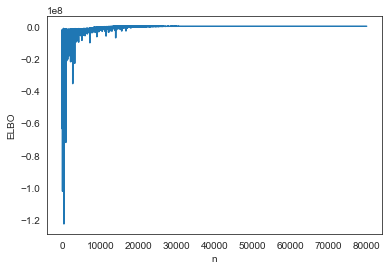

In [11]:
advi_elbo = pd.DataFrame(
    {'ELBO': -(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

## Drawing samples

In [12]:
trace = advi_fit.sample(draws=10000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126165cf8>,
      dtype=object)

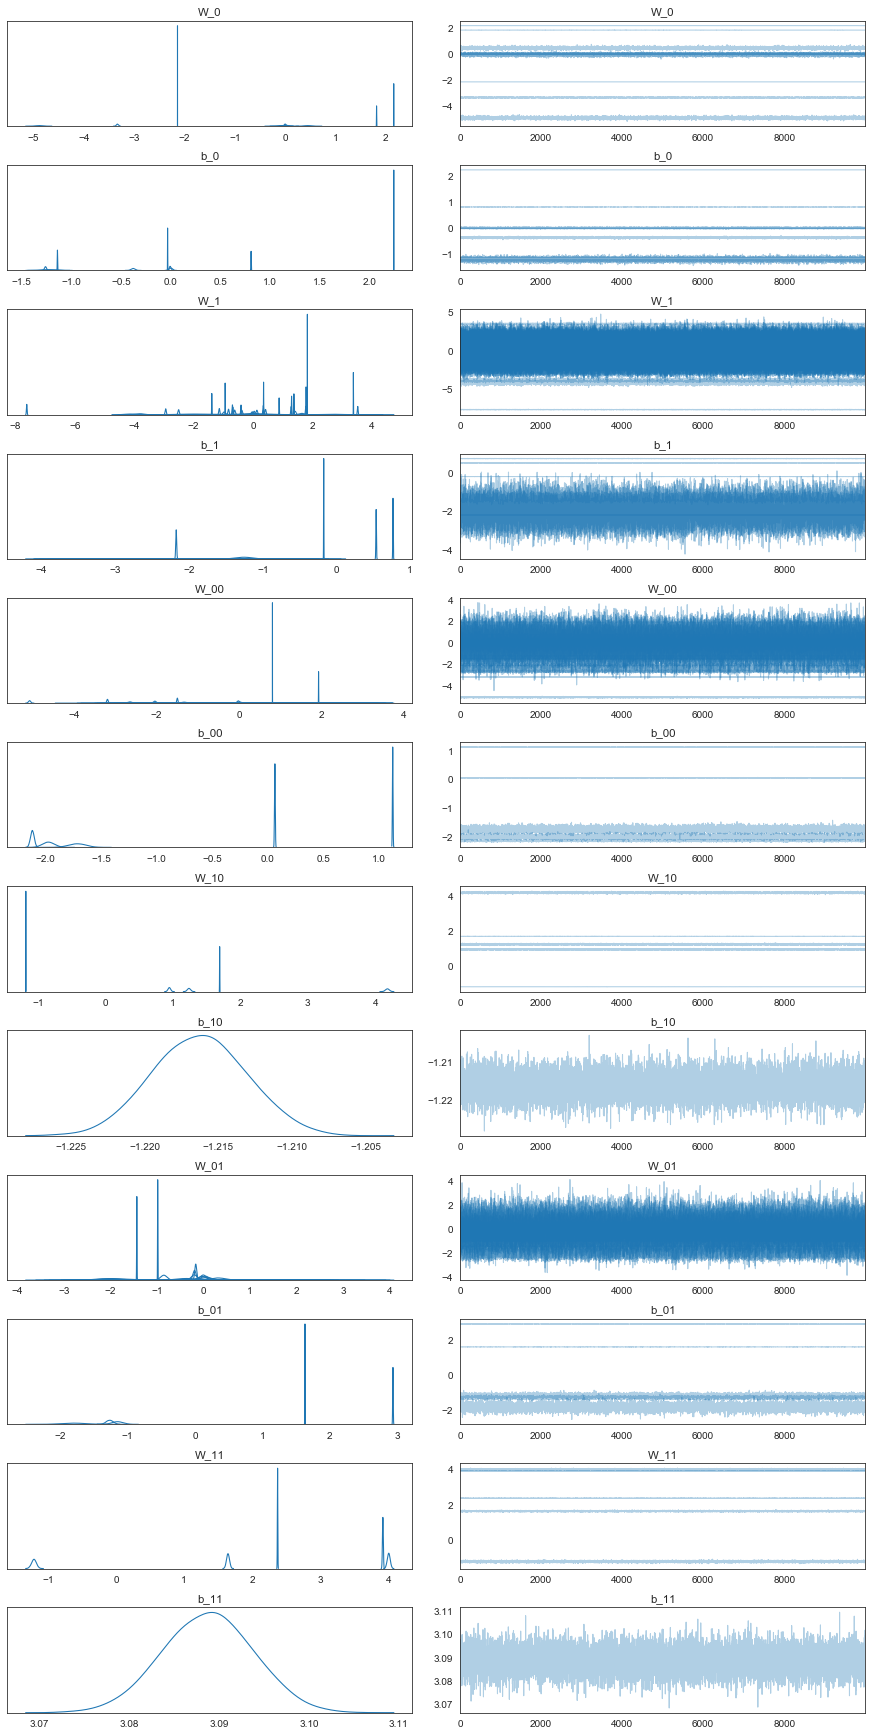

In [13]:
pm.traceplot(trace)
# pm.summary(trace)
# pm.forestplot(trace)

## Checking

(5, 100)
(5, 100)


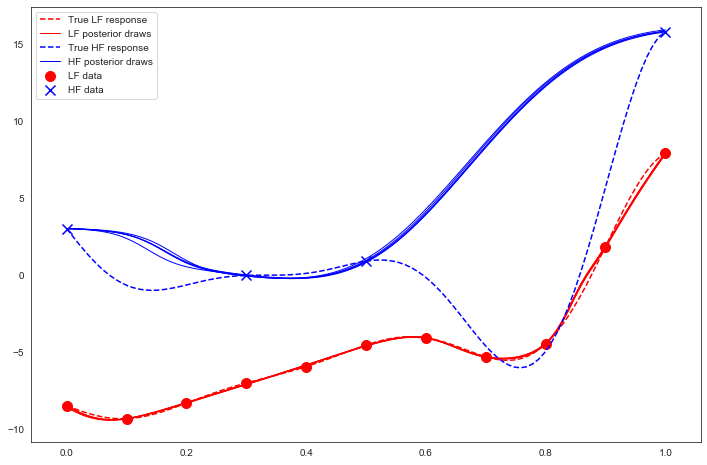

In [14]:
# checking posterior draws

preds_low =[DNN(X_p, trace['W_0'][i], trace['b_0'][i], trace['W_1'][i], trace['b_1'][i],
                trace['W_00'][i], trace['b_00'][i], trace['W_10'][i], trace['b_10'][i], 
                trace['W_01'][i], trace['b_01'][i], trace['W_11'][i], trace['b_11'][i])[0].eval()
 for i in range(5)]
preds_low = np.asarray(preds_low)
outputs_low = preds_low.reshape(preds_low.shape[0],preds_low.shape[1])
print(np.shape(outputs_low))

preds_high =[DNN(X_p, trace['W_0'][i], trace['b_0'][i], trace['W_1'][i], trace['b_1'][i], 
                 trace['W_00'][i], trace['b_00'][i], trace['W_10'][i], trace['b_10'][i], 
                 trace['W_01'][i], trace['b_01'][i], trace['W_11'][i], trace['b_11'][i])[1].eval()
 for i in range(5)]
preds_high = np.asarray(preds_high)
outputs_high = preds_high.reshape(preds_high.shape[0],preds_high.shape[1])
print(np.shape(outputs_high))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

ax.plot(X_p, f_l(X_p), 'r--', label='True LF response')
ax.scatter(X_l, Y_l, color='red', marker='o', s=100, label='LF data')
ax.plot(X_p,outputs_low[0].T, lw=1, label='LF posterior draws', color='red')
ax.plot(X_p,outputs_low[1:].T, lw=1, color='red')

ax.plot(X_p, f_h(X_p), 'b--', label='True HF response')
ax.scatter(X_h, Y_h, color='blue', marker='x', s=100, label='HF data')
ax.plot(X_p,outputs_high[0].T, lw=1, label='HF posterior draws',color='blue')
ax.plot(X_p,outputs_high[1:].T, lw=1, color='blue')

ax.legend()
plt.show()

## Testing on whole data

In [15]:
# # testing on whole data 
# x_tensor.set_value(X_new)

In [16]:
# posterior_preds = pm.sample_posterior_predictive(trace, 1000, neural_network)

# mean_prediction = np.mean(posterior_preds['out'], axis=0)
# stddev_prediction = np.std(posterior_preds['out'], axis=0)
# print (posterior_preds['out'].shape)

In [17]:
# fig = plt.figure(figsize=(8, 10))

# ax1 = fig.add_subplot(211)
# ax1.plot(X_data, y_data, 'bs', alpha=0.5, label='(x, y)') # full data (train+test)
# ax1.plot(X_new, posterior_preds['out'][0] , lw=2, label='posterior predictive draws')
# ax1.plot(X_new, posterior_preds['out'][1:5].reshape(4,X_new.shape[0]).T, lw=2, label='posterior predictive draws')
# ax1.legend()

# ax2 = fig.add_subplot(212)
# ax2.plot(X_data, y_data, 'bs', alpha=0.5, label='(x, y)') # full data (train+test)
# ax2.plot(X_new, mean_prediction ,lw=2, label='mean')
# ax2.fill_between(X_new.ravel(), (mean_prediction-2*stddev_prediction).ravel(), (mean_prediction+2*stddev_prediction).ravel(), alpha = 0.3, color = 'orange',label='uncertanity')
# # ax2.errorbar(X_new, mean_prediction, yerr=1.96*stddev_prediction, fmt='o', label='uncertanity', color='red',markersize=4)
# ax2.legend()

# plt.show()

In [18]:
# print(trace.get_values('w_in_1').shape)

# param_samples_ADVI = pd.DataFrame(
#     {'w_in_1[0,0]': trace.get_values('w_in_1').reshape(trace.get_values('w_in_1').shape[0],trace.get_values('w_in_1').shape[2])[:,0], 
#      'w_in_1[0,1]': trace.get_values('w_in_1').reshape(trace.get_values('w_in_1').shape[0],trace.get_values('w_in_1').shape[2])[:,1]})

# _ = sns.scatterplot(x='w_in_1[0,0]', y='w_in_1[0,1]', data=param_samples_ADVI).set_title('ADVI')

## Testing on only test data 

In [19]:
# # testing on test data
# y_tensor.set_value(y_test)
# x_tensor.set_value(X_test)

# posterior_preds_test = pm.sample_posterior_predictive(trace, 1000, neural_network)
# mean_prediction_test = np.mean(posterior_preds_test['out'], axis=0)
# stddev_prediction_test = np.std(posterior_preds_test['out'], axis=0)
# print (posterior_preds_test['out'].shape)

# prediction_data_test = pd.DataFrame(
#     {'ADVI': mean_prediction_test.flatten(), 
#      'actual': y_test.flatten(),
#      'error_ADVI': (mean_prediction_test - y_test).flatten()})

# print (prediction_data_test)

# _ = sns.lmplot(y='ADVI', x='actual', data=prediction_data_test,
#                line_kws={'color': 'red', 'alpha': 0.5})


# RMSE = np.sqrt(np.mean(prediction_data_test.error_ADVI ** 2))

# print(f'RMSE for ADVI test predictions = {RMSE:.3f}')